In [1]:
import numpy as np
import re
import ast
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import cell_order_log_analysis

In [2]:
FONTSIZE = 16
LINESTYLE = (0,(4,4))
LINEWIDTH = 2.5
SAVE_FIG = False

CELL_ORDER_LOG_PATTERN = ".*ts_ms:(?P<ts>\d*) slice_metrics:(?P<metrics_dict>.*)"
CELL_ORDER_CONF_PATTERN = ".*Cell-Order configuration: ((?P<conf_dict>{.*}))"

RESERVATION = 'RES129287'
cell_order_log_filename = '../data/cell-order-' + RESERVATION + '.log'
STAT_ANALYSIS_START_TIME = 813
STAT_ANALYSIS_END_TIME = 10000

SLA_PERIOD = 30 # seconds over which the SLAs are negotiated


slice_delay_budget_msec = {0: [60, 90], 1: [30, 50], 2: [5, 15]}

Cell-Order log line:

`2022-09-10 07:01:13,408 INFO     ts_ms:1662793273408 slice_metrics:{0: {'cur_slice_mask': '11111000000000000', 'dl_latency [msec]': 21.068701301700617, 'new_num_rbgs': 5, 'num_slice_users': 1, 'tx_brate downlink [Mbps]': 2.6001014999999996, 'dl_buffer [bytes]': 6610.4}, 1: {'cur_slice_mask': '00000111110000000', 'dl_latency [msec]': 8.969970247895116, 'new_num_rbgs': 5, 'num_slice_users': 1, 'tx_brate downlink [Mbps]': 0.784571775, 'dl_buffer [bytes]': 841.5}, 2: {'cur_slice_mask': '00000000001111100', 'dl_latency [msec]': 17.10698629155465, 'new_num_rbgs': 5, 'num_slice_users': 1, 'tx_brate downlink [Mbps]': 3.2608447499999995, 'dl_buffer [bytes]': 7144.95}}`


In [3]:
data, slice_delay_budget_msec = cell_order_log_analysis.read_cell_order_log(cell_order_log_filename)
cell_order_log_analysis.summarize_over_sla_period(data, SLA_PERIOD)

[60, 90]
[30, 50]
[0, 15]


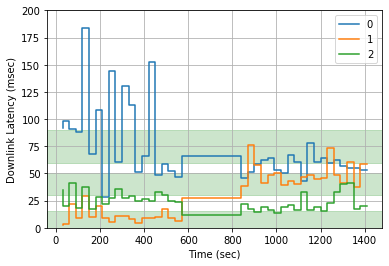

In [4]:
plt.figure()

for s_idx, metrics in data.items():
    plt.step(metrics['ts_sec'], metrics['lat_msec'], 
             label=s_idx, where='pre')

for _, budget in slice_delay_budget_msec.items():
    print(budget)
    plt.gca().axhspan(budget[0], budget[1], alpha=0.2, color='green')

# plt.yscale('log')
plt.ylim([0,200])

plt.xlabel('Time (sec)')
plt.ylabel('Downlink Latency (msec)')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig('../outputs/' + RESERVATION + '_lat.png')

plt.show()


In [5]:
cell_order_log_analysis.print_latency_stats(data, 
                                            STAT_ANALYSIS_START_TIME, 
                                            STAT_ANALYSIS_END_TIME, 
                                            slice_delay_budget_msec)


	Latency values for slice 0: ([60,90]: 45.00%) ([55,95]: 65.00%) ([50,100]: 90.00%) (Low-Lat Rate: 100.00%)

[66.38827484 45.80276924 51.1796674  58.5033404  62.65392207 64.29646641
 53.04132856 50.68416777 66.54322256 60.18110812 43.38733337 78.06822115
 60.24153175 64.0725619  59.27625555 62.72109971 56.72377563 54.62923184
 55.31532744 52.80002786]

	Latency values for slice 1: ([30,50]: 65.00%) ([25,55]: 75.00%) ([20,60]: 85.00%) (Low-Lat Rate: 70.00%)

[27.08811519 38.80490219 75.75286141 58.18255614 40.86988475 48.4463219
 50.09417837 39.18433749 43.48148123 40.30977404 46.41072281 48.3128277
 44.86624881 45.54872244 73.54385177 48.95496105 41.11927676 60.08167945
 37.35826257 58.25614359]

	Latency values for slice 2: ([0,15]: 15.00%) ([0,20]: 65.00%) ([0,25]: 80.00%) (Low-Lat Rate: 15.00%)

[11.97067126 22.20497032 16.87750907 14.71845953 18.7024213  16.61355158
 13.7385168  18.67320407 20.56493953 16.40696435 32.72549963 15.94641566
 19.39504984 15.1756467  23.0877061  32.998

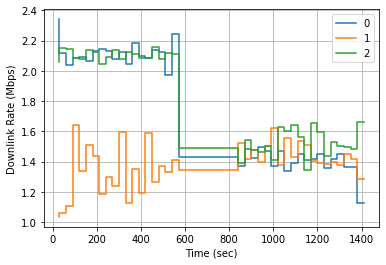

In [6]:
plt.figure()

for s_idx, metrics in data.items():
    plt.step(metrics['ts_sec'], metrics['tx_mbps'], 
             label=s_idx, where='pre')

plt.xlabel('Time (sec)')
plt.ylabel('Downlink Rate (Mbps)')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig('../outputs/' + RESERVATION + '_rate.png')

plt.show()

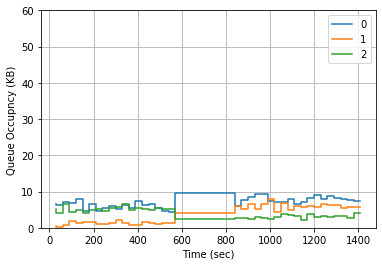

In [7]:
plt.figure()

for s_idx, metrics in data.items():
    plt.step(metrics['ts_sec'], metrics['buf_bytes'] / 1e3, 
             label=s_idx, where='pre')

plt.ylim([0,60])

plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupncy (KB)')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig('../outputs/' + RESERVATION + '_buf.png')

plt.show()

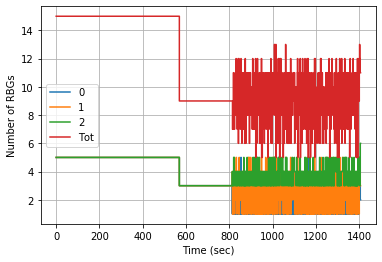

In [8]:
plt.figure()

for s_idx, metrics in data.items():
    plt.step(metrics['raw_ts_sec'], metrics['raw_n_rbgs'], 
             label=s_idx, where='pre')

cum_n_rbgs = np.zeros_like(data[list(data)[0]]['raw_n_rbgs'])
ts_cum_n_rbgs = data[list(data)[0]]['raw_ts_sec']
for s_idx, metrics in data.items():
    cur_n_rbgs = metrics['raw_n_rbgs']
    len_diff = len(cur_n_rbgs) - len(cum_n_rbgs)
    if (len_diff > 0):
        cum_n_rbgs = np.append(np.zeros(len_diff).astype(int), cum_n_rbgs)
        ts_cum_n_rbgs = metrics['raw_ts_sec']
    elif (len_diff < 0):
        cur_n_rbgs = np.append(np.zeros(-1*len_diff).astype(int), cur_n_rbgs)
    cum_n_rbgs += cur_n_rbgs
plt.step(ts_cum_n_rbgs, cum_n_rbgs, label='Tot', where='pre')

plt.xlabel('Time (sec)')
plt.ylabel('Number of RBGs')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig('../outputs/' + RESERVATION + '_rbgs.png')

plt.show()

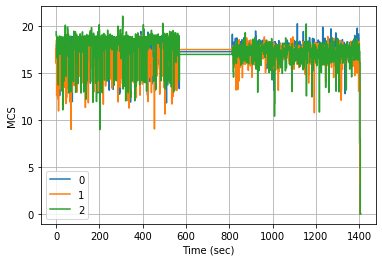

In [15]:
plt.figure()

for s_idx, metrics in data.items():
    plt.step(metrics['raw_ts_sec'], metrics['raw_mcs'], 
             label=s_idx, where='pre')

plt.xlabel('Time (sec)')
plt.ylabel('MCS')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig('../outputs/' + RESERVATION + '_mcs.png')

plt.show()